# 1. Importing all the requried packages and modules

In [1]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# 2. Data Loading

In [2]:
data_dir = 'data'

In [3]:
categories  = ['cloudy', 'desert', 'green_area', 'water']
data = []
data_labels = []

for categorie in categories :
    folder_path = os.path.join(data_dir, categorie)
    image_paths = os.listdir(folder_path)
    data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])
    data_labels.extend([categorie] * len(image_paths))
data = pd.DataFrame({'Image_Path' : data, 'labels' : data_labels})
data

,Image_Path,labels
0,data\cloudy\train_10021.jpg,cloudy
1,data\cloudy\train_10043.jpg,cloudy
2,data\cloudy\train_10070.jpg,cloudy
3,data\cloudy\train_10081.jpg,cloudy
4,data\cloudy\train_10096.jpg,cloudy
...,...,...
5626,data\water\SeaLake_995.jpg,water
5627,data\water\SeaLake_996.jpg,water
5628,data\water\SeaLake_997.jpg,water
5629,data\water\SeaLake_998.jpg,water


# 3. Data Visualization 

Displaying Some Sample images of 'cloudy' categorie : 


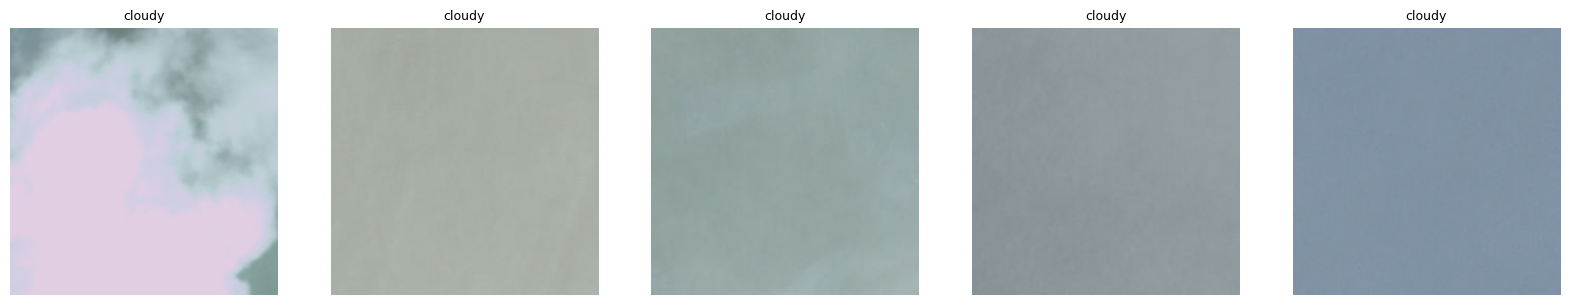

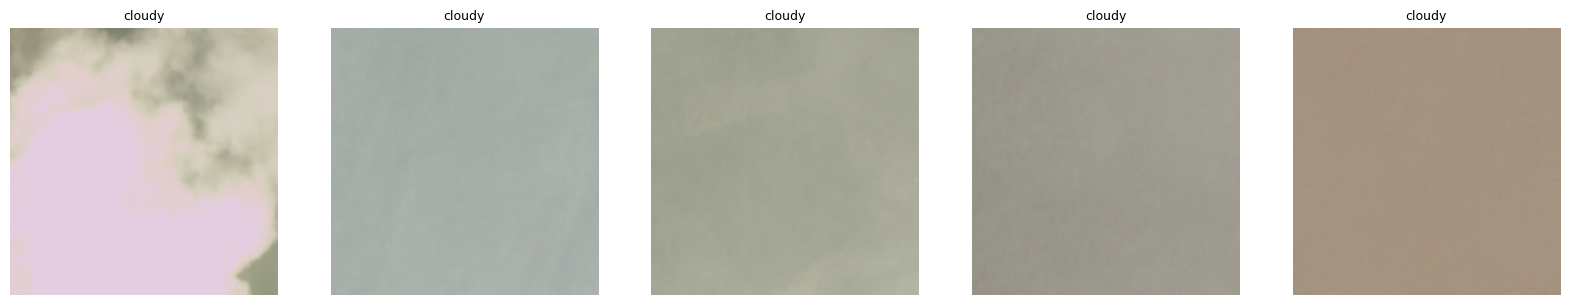

Displaying Some Sample images of 'desert' categorie : 


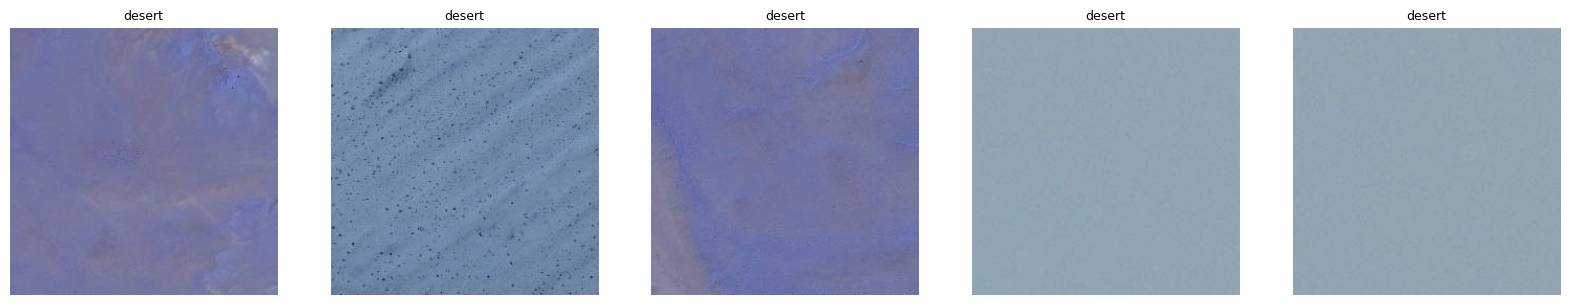

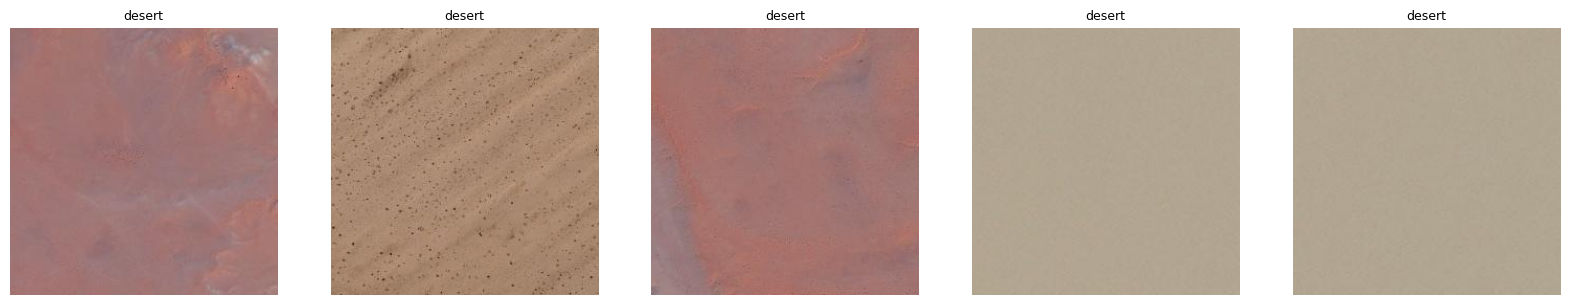

Displaying Some Sample images of 'green_area' categorie : 


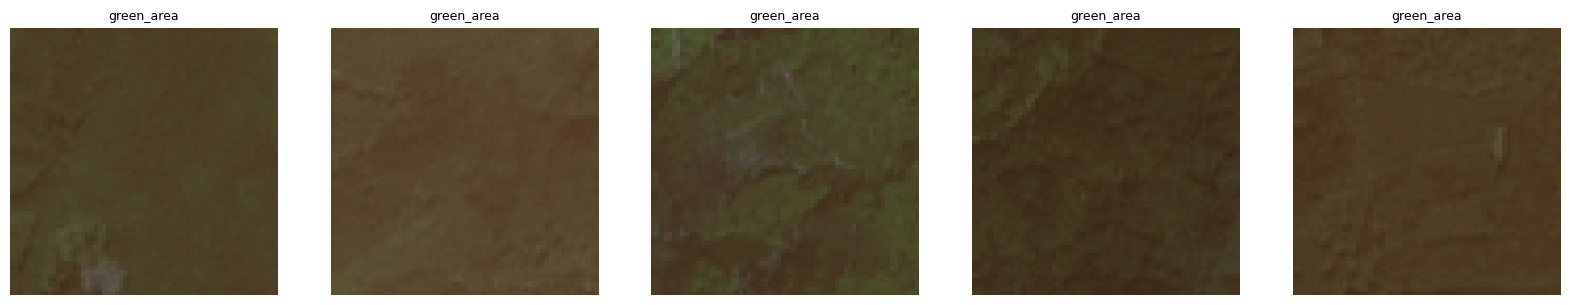

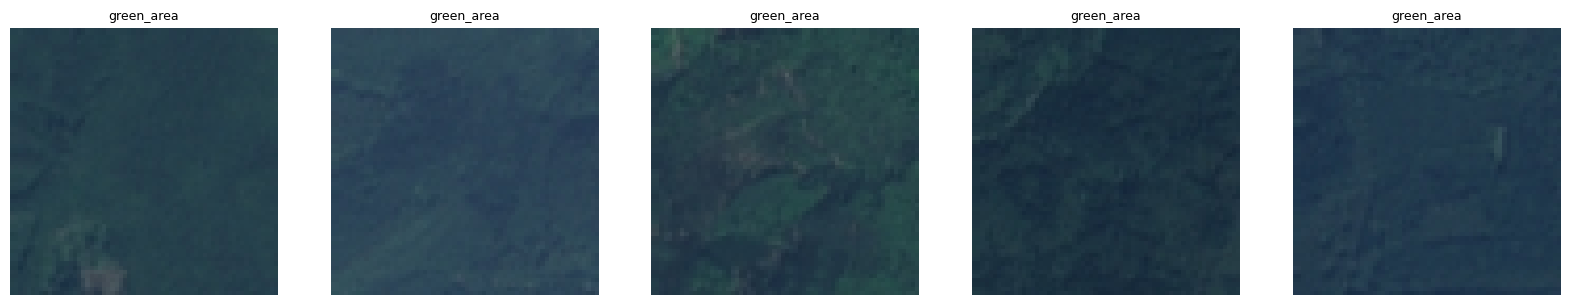

Displaying Some Sample images of 'water' categorie : 


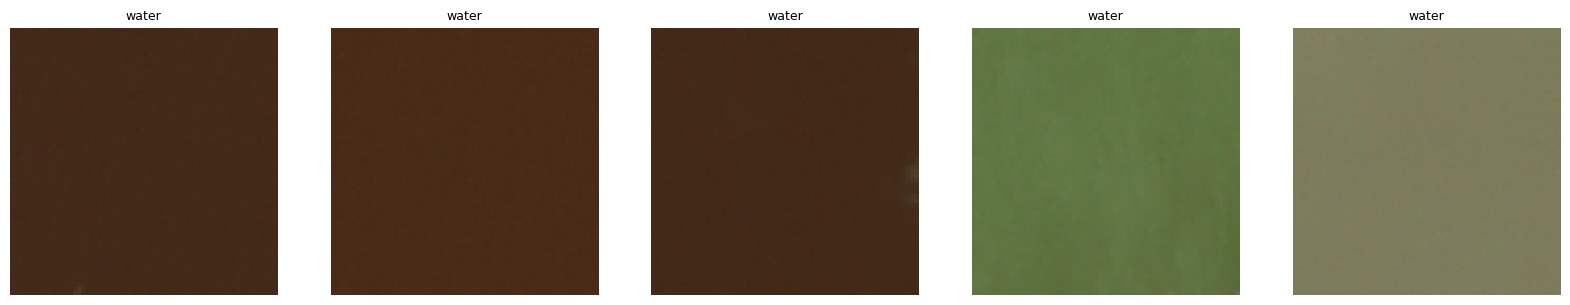

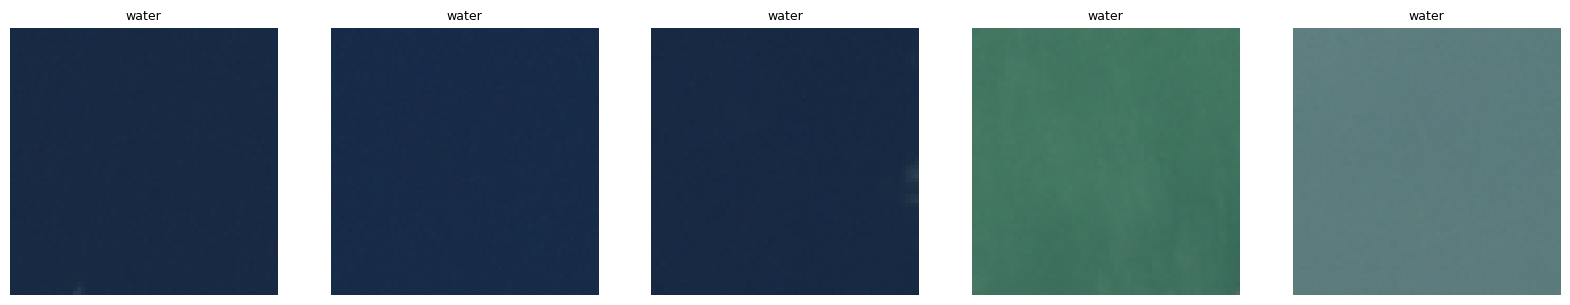

In [4]:
labels = ['cloudy', 'desert', 'green_area', 'water']

for label in labels:
    sample_images = data[data['labels'] == label]['Image_Path'].reset_index(drop=True)[:5]

    print(f"Displaying Some Sample images of '{label}' categorie : ")
    plt.figure(figsize=(20, 8))
    # Displaying Some Sample images in BGR
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        img = cv2.imread(sample_images[i])
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')
    plt.show()
    # Displaying Some Sample images in RGB
    plt.figure(figsize=(20, 8))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1 + 5)
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')
        
    plt.show()

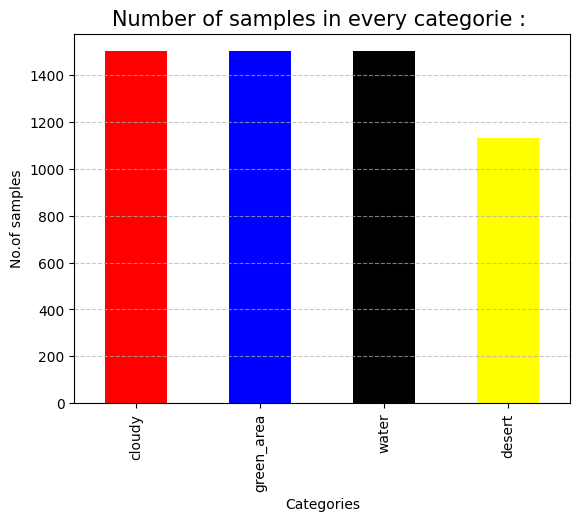

In [5]:
data['labels'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'black', 'yellow'])
plt.title('Number of samples in every categorie : ', fontsize = 15)
plt.xlabel('Categories')
plt.ylabel('No.of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Data Preprocessing and Augmentation

In [6]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.25,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    zoom_range = 0.2
)


In [7]:
# Training Data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test Data (Separate folder or another 10% of data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=10,
    class_mode='categorical',
    shuffle=True
)

Found 4224 images belonging to 4 classes.
Found 1407 images belonging to 4 classes.
Found 5631 images belonging to 4 classes.


In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# 5. Building the models

In [15]:
ResNet50V2_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(75,75,3))

In [16]:
# Freeze the layers of the base model
for layer in ResNet50V2_model.layers:
    layer.trainable = False

# Add custom layers
x = ResNet50V2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model4 = Model(inputs = ResNet50V2_model.input, outputs=predictions)

# 6. Compiling and Training the models

In [17]:
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [18]:
# EarlyStoping the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# Learning Rate Decay
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [19]:
# Train the model
mc4 = ModelCheckpoint('best_ResNet50V2_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model4.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, mc4, lrd]
)

# 21min 19sec

c:\Users\Dell\anaconda3\envs\dl_kerasocr\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 115s 819ms/step - accuracy: 0.8812 - loss: 0.3365 - val_accuracy: 0.9566 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 115s 870ms/step - accuracy: 0.9552 - loss: 0.1330 - val_accuracy: 0.9524 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 100s 763ms/step - accuracy: 0.9607 - loss: 0.1026 - val_accuracy: 0.9638 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 97s 737ms/step - accuracy: 0.9576 - loss: 0.1461 - val_accuracy: 0.9673 - val_loss: 0.1101 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 101s 764ms/step - accuracy: 0.9649 - loss: 0.0968 - val_accuracy: 0.9652 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 102s 771ms/step - accuracy: 0.9733 - loss: 0.0707 - val_accuracy: 0.9652 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 110s 836ms/step - accurac

In [26]:
# Save the model
model4.save("model4.keras")

# 7. Models Evaluate on validation data

In [20]:
val_loss, val_accuracy = model4.evaluate(val_data)
print(f"Model4 Validation Loss: {val_loss}")
print(f"Model4 Validation Accuracy: {val_accuracy}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.9454 - loss: 0.2041
Model4 Validation Loss: 0.1093122735619545
Model4 Validation Accuracy: 0.968017041683197


**We achieved the highest accuracy with the ResNet50V2 model, so we are taking that model's history and observing its graphs.**

# 8. Model performance Visualization

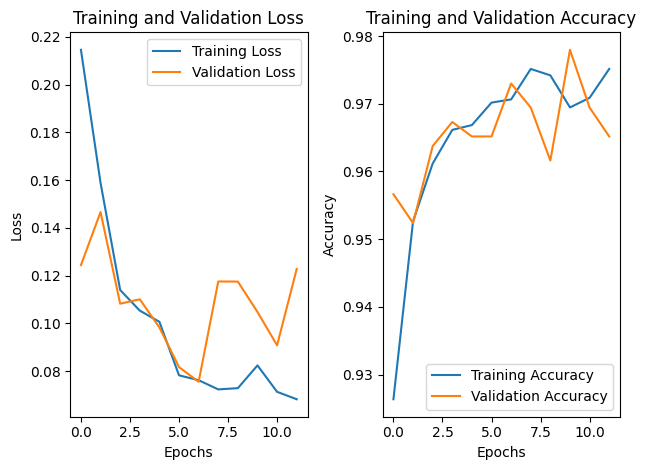

In [21]:
# Plotting the training and validation los

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [22]:
class_names = list(val_data.class_indices.keys())

# Get predictions for the validation data
val_predictions = model4.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)  # Predicted classes
y_true = val_data.classes  # True classes from the generator

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step


In [23]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


Test Classification Report:
              precision    recall  f1-score   support

      cloudy       0.98      0.92      0.95       375
      desert       0.92      0.99      0.96       282
  green_area       0.98      0.97      0.97       375
       water       0.95      0.98      0.96       375

    accuracy                           0.96      1407
   macro avg       0.96      0.96      0.96      1407
weighted avg       0.96      0.96      0.96      1407



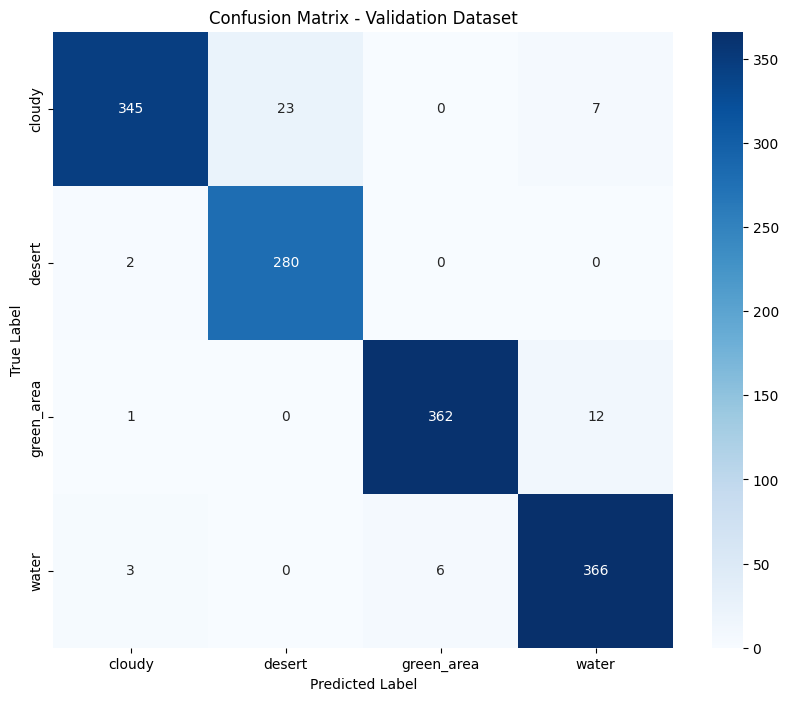

In [24]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 9. Output Prediction and Probabilities test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


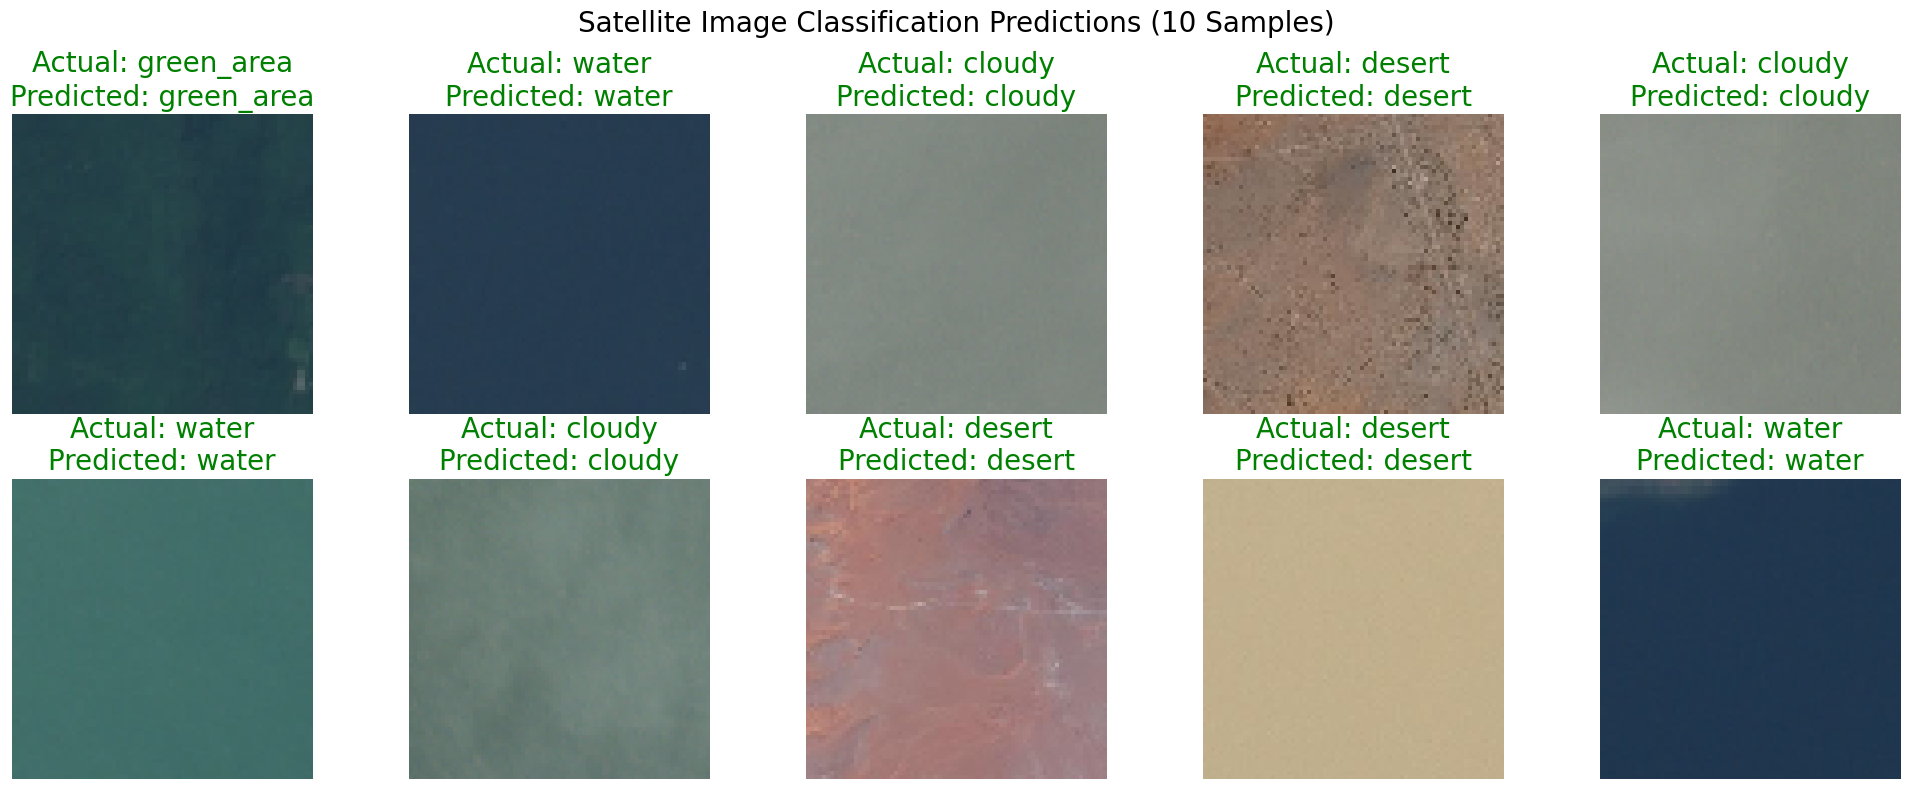

In [25]:
# Get class names from the generator
class_names = list(test_data.class_indices.keys())

num_rows = int(np.ceil(10 / 5))  # Calculate rows dynamically

# Set up the figure size
plt.figure(figsize=(20, 8))

# Extract 10 images and their labels from the test generator
test_images, test_labels = next(test_data)  # Fetch a single batch from test_data
test_images = test_images[:10]
test_labels = test_labels[:10]

# Loop through the samples for display
for i in range(10): 
    # Preprocess the image for prediction
    img = test_images[i]  # Already preprocessed by ImageDataGenerator
    true_class = np.argmax(test_labels[i])  # Get the true label
    predicted_class = np.argmax(model4.predict(np.expand_dims(img, axis=0)), axis=-1)  # Predict class
    # Determine if the prediction is correct
    is_correct = true_class == predicted_class[0]
    # Set the color based on whether the prediction is correct
    title_color = 'green' if is_correct else 'red'
    # Display the image
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img)  # Image is already scaled between 0 and 1
    plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[predicted_class[0]]}", fontsize = 20, color=title_color)
    plt.axis('off')

# Add a global title
plt.suptitle('Satellite Image Classification Predictions (10 Samples)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust spacing for the title
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Class: desert


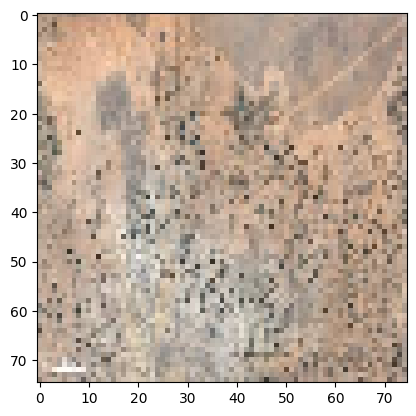

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = "./test4.jpg"  # Replace with your image path
img = image.load_img(img_path, target_size=(75, 75))  # Resize to target size

# Convert to numpy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply the same preprocessing as training
datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2
)

# Process image using datagen
img_preprocessed = next(datagen.flow(img_array, batch_size=1))

# Make prediction
predictions = model4.predict(img_preprocessed)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get class labels
class_labels = list(train_data.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")

plt.imshow(img)